# Power Splitter Demo

This is an introductory demo for using angler for inverse design.   

Here we will walk through designing a 50-50 power splitter.

## Setup

We'll first import all of the packages we need and set up our notebook.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import copy

# add angler to path (not necessary if pip installed)
import sys
sys.path.append("..")

# import the main simulation and optimization classes
from angler import Simulation, Optimization

# import some structure generators
from angler.structures import three_port, two_port

%load_ext autoreload
%autoreload 2
%matplotlib inline

Now let's define some of the parameters we'll be using in our optimization

In [28]:
# define the similation constants
lambda0 = 1.55e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 1e-1                   # grid size (L0)
NPML = [20, 20]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 1e-9           # amplitude of modal source (make around 1 for nonlinear effects)

In [29]:
# define material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity

In [44]:
# geometric parameters for a 1 -> 2 port device
L = 3       # length of box (L0) = micron 
H = 4     # height of box (L0)
w = .3        # width of waveguides (L0)
d = H/1.5     # distance between waveguides (L0)
l = 5         # length of waveguide from PML to box (L0)
spc = 3       # space between box and PML (L0)

## Defining the Simulation Object
Now, we can create an initial relative permittivity, define our design region, and create the `Simulation` object for our domain.

Computed a domain with 170 grids in x and 140 grids in y
The simulation has 15 grids per free space wavelength


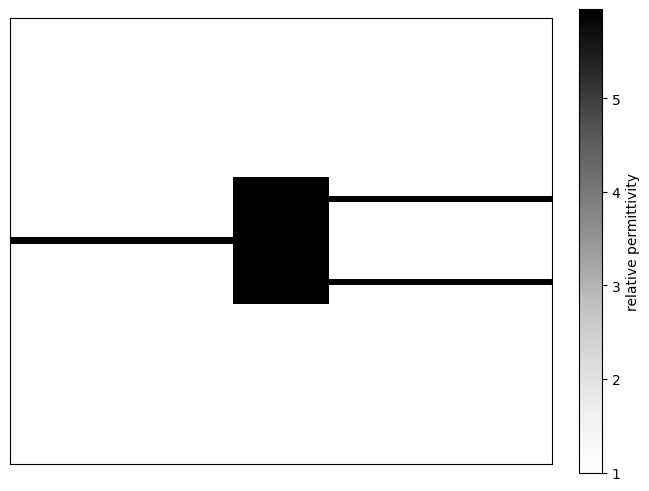

In [45]:
# define permittivity of three port system
eps_r, design_region = three_port(L, H, w, d, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

# make a new simulation object
simulation = Simulation(omega, eps_r, dl, NPML, pol)

print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))

# 1 L = 10 grid points, starts at 150 grids in x ...
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))

# plot the permittivity distribution
simulation.plt_eps(outline=False)
plt.show()

`Simulation` objects are used for running the actual FDFD simulations and we define our optimizations over them.

## Sources and Probes

With our simulation defined, we may now define the modal profiles of our input and output ports.  

We will first add a modal source to our simulation corresponding to the port on the left.

Then, we'll create two temporary simulations that are identical to the original, add modal sources for the top and bottom ports, and use these to get numpy arrays corresponding to the top and bottom probes of the device.  While in the code we are labelling these `J_top` and `J_bot`, in the paper, these are called $\mathbf{m}_{t}$ and $\mathbf{m}_b$ respectively

In [14]:
# set the input waveguide modal source
simulation.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[NPML[0]+int(l/2/dl), ny], width=int(H/2/dl), scale=0)
simulation.setup_modes()

# make a new simulation to get the modal profile of the top output port
top = Simulation(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], width=int(H/2/dl))
top.setup_modes()
J_top = np.abs(top.src)

# make a new simulation to get the modal profile of the bottom output port
bot = Simulation(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], width=int(H/2/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

# define adjoint src 
simulation.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], width=int(H/2/dl), scale=1e-9)
simulation.setup_modes()

Now we can use `J_top` and `J_bot` as probes in our objective function.  We'll no longer need the `top` and `bot` Simulations.

We can plot solve the simulation for the electric and magnetic fields and then plot the results.

(200, 140)


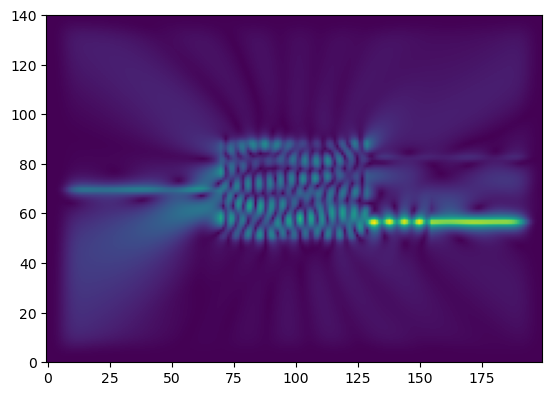

In [23]:
# set source and solve for electromagnetic fields
(Hx, Hy, Ez) = simulation.solve_fields()
#simulation.plt_abs(outline=True, cbar=True);
print(design_region.shape)
plt.figure(1)
plt.imshow(np.abs(Ez).T)
plt.ylim(0,len(Ez[0]))
plt.show()

In [ ]:
# set source and solve for electromagnetic fields
(Hx, Hy, Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

## Normalizing

As an optional step, we'll normalize the modal amplitudes such that $|J^T E|^2 = 1$ for perfect transmission to the port corresponding to $J$.

To do this, we'll make another temporary simulation with just a straight waveguide of the same source as our original three port.

We'll then compute $|J^T E|^2$ for the output port, and normalize `J_in` and `J_out` using this. 

computed a scale of 2.7336059102792776e-17


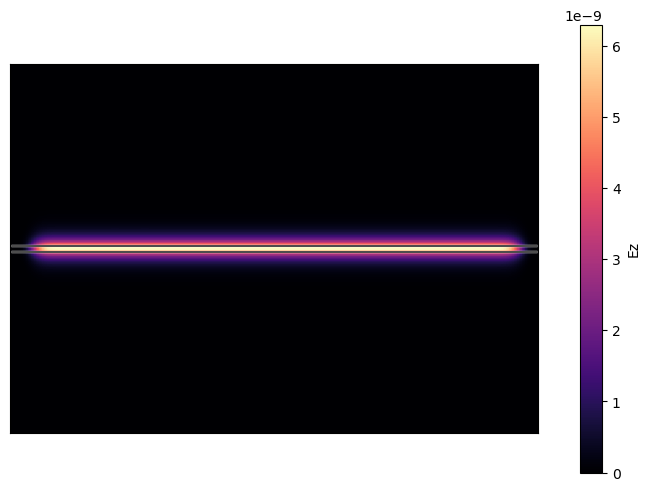

In [8]:
# compute straight line simulation
eps_r_wg, _ = two_port(L, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx_wg, Ny_wg) = eps_r_wg.shape
nx_wg, ny_wg = int(Nx_wg/2), int(Ny_wg/2)            # halfway grid points     
simulation_wg = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
simulation_wg.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny_wg], int(Ny/3), scale=source_amp)
simulation_wg.setup_modes()

# compute normalization
sim_out = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(Ny/3))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)
(_, _, Ez_wg) = simulation_wg.solve_fields()
SCALE = np.sum(np.square(np.abs(Ez_wg*J_out)))
J_out = J_out
print('computed a scale of {}'.format(SCALE))

simulation_wg.plt_abs(outline=True, cbar=True);

J_top = J_top / np.sqrt(SCALE)
J_bot = J_bot / np.sqrt(SCALE)

## Changing the design region

Optionally, we can also change the design region to several different styles before optimization.  

Here we'll use `random_sym` which randomly assigns each pixel within the design region betwee 1 and the maximum permittivity.  

This is mirrored across y=0.

Making it symmetric leads to more symmetric final devices.

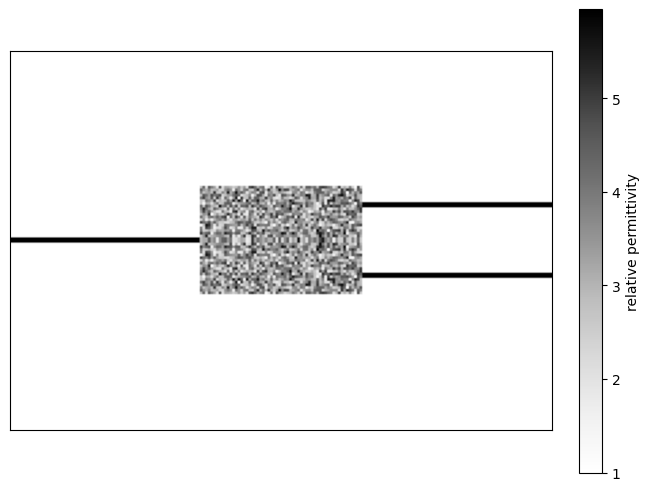

In [9]:
# changes design region. 'style' can be one of {'full', 'empty', 'halfway', 'random', 'random_sym'}.
simulation.init_design_region(design_region, eps_m, style='random_sym')
simulation.plt_eps(outline=False)
plt.show()

## Defining Objective Functions

Now is one of the most important steps: defining the objective function for optimization / inverse design.

To do this, we define a function `J` which takes in the linear fields as the first argument and the nonlinear fields as a second argument.

Until we make this more flexible, if your problem is linear, you still need the nonlinear fields argument, but you dont have to use it within the body of the function. 

We require that you define your numpy operations within J using the autograd wrapper for numpy.

This allows us to automatically compute the partial derivatives of $J$ w.r.t. $E$ and $E_{nl}$, which are used in the adjoint.  

This is super helpful when you define complicated objective functions and dont feel like computing these by hand!

Below is an example of an objective function where the top and bottom port transmissions are directly multiplied.

`angler` will try to maximize `J` w.r.t the permittivity in the design region.  Since we're multiplying the transmissions here, a highest possible value of `J = 1` will occur when each port is at 50% transmission, which is what we want.

In [10]:
# define objective function  (equal power transmission to bottom and top)
import autograd.numpy as npa
from angler.objective import Objective, obj_arg

arg1 = obj_arg('ez', component='Ez', nl=False)

def J(ez):
    linear_top =     1*npa.sum(npa.square(npa.abs(ez*J_top)))
    linear_bot =     1*npa.sum(npa.square(npa.abs(ez*J_bot)))
    objfn = linear_top * linear_bot * 4
    return objfn

objective = Objective(J, arg_list=[arg1])

## Defining the Optimization

Now we are ready to define the `Optimization`, which will perform the inverse design on top of our `simulation`.  

We give the optimization our objective function, simulation object, design region, and specify the maximum permittivity to allow.

Also, we pass in some optional arguments that define the filtering and projection that are used to create smooth feature sizes.

`R` controls the minimum feature size.  
`beta` controls how strongly to bias the permittivitiy to be either air or material.

See the supplementary information of our paper (coming soon) for more details.

The `Optimization` object takes a little bit of time to initialize because we need to set up the spatial filter.

In [11]:
# make optimization object
R = 4          # filter radius of curvature (pixels)  (takes a while to set up as R > 5-10)
beta = 300     # projection strength
eta= 0.50      # projection halfway

optimization = Optimization(objective=objective, simulation=simulation, design_region=design_region, eps_m=eps_m, R=R, beta=beta, eta=eta)

  0% (0 of 151) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (2 of 151) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00
  2% (4 of 151) |                        | Elapsed Time: 0:00:00 ETA:   0:00:05
  3% (6 of 151) |                        | Elapsed Time: 0:00:00 ETA:   0:00:05
  5% (8 of 151) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:05
  6% (10 of 151) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:05
  7% (12 of 151) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:05
  9% (14 of 151) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:05
 10% (16 of 151) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:05
 11% (18 of 151) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:05
 13% (20 of 151) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:04
 14% (22 of 151) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:04
 16% (25 of 151) |###                   

## Checking Adjoint Derivatives

We allow users to check that their adjoint derivatives match finite difference numerical derivatives.

This is good practice to make sure things are working correctly

In [12]:
# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(Npts=5, d_rho=5e-4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

adjoint gradient   = [-0.0013005759344598602, -0.003120587468332678, -0.0009697825689550184, -0.001296733917499803, -0.003511498505235209]
numerical gradient = [-0.001299314935137609, -0.003124908825866742, -0.0009735745070417988, -0.0012988747533763424, -0.003514504804449578]


## Running the Optimization

Finally, we can run the optimization / inverse design.

To do this, we simply call `Optimization.run()` with some parameters.

You can try out different optimization methods and parameters, for more info, check out `angler/optimization.py`.

In [13]:
# run optimization for 400 steps
new_eps = optimization.run(method='lbfgs', Nsteps=400)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2400     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.77815D-03    |proj g|=  1.42789D-02


 ObjectiveFn: ------ Iteration:  0/400 ETA:  --:--:--
 ObjectiveFn: 0.00298 Iteration:  0/400 ETA:  --:--:--



At iterate    1    f= -2.98000D-03    |proj g|=  2.51844D-02


 ObjectiveFn: 0.00639 Iteration:  1/400 ETA:   0:28:30



At iterate    2    f= -6.39231D-03    |proj g|=  4.23485D-02


 ObjectiveFn:  0.037 Iteration:  2/400 ETA:   0:28:09



At iterate    3    f= -3.69977D-02    |proj g|=  5.86214D-02


 ObjectiveFn:  0.058 Iteration:  3/400 ETA:   0:13:49



At iterate    4    f= -5.80382D-02    |proj g|=  9.81286D-02


 ObjectiveFn: 0.0727 Iteration:  4/400 ETA:   0:28:10



At iterate    5    f= -7.26764D-02    |proj g|=  7.71493D-02


 ObjectiveFn: 0.0802 Iteration:  5/400 ETA:   0:14:23



At iterate    6    f= -8.02472D-02    |proj g|=  6.17718D-02


 ObjectiveFn:  0.105 Iteration:  6/400 ETA:   0:28:47



At iterate    7    f= -1.04907D-01    |proj g|=  1.18306D-01


 ObjectiveFn:  0.135 Iteration:  7/400 ETA:   0:13:38



At iterate    8    f= -1.34594D-01    |proj g|=  1.22713D-01


 ObjectiveFn:  0.148 Iteration:  8/400 ETA:   0:28:19



At iterate    9    f= -1.47744D-01    |proj g|=  7.68583D-02


 ObjectiveFn:  0.155 Iteration:  9/400 ETA:   0:14:13



At iterate   10    f= -1.55280D-01    |proj g|=  3.92251D-01


 ObjectiveFn:  0.165 Iteration:  10/400 ETA:   0:13:39



At iterate   11    f= -1.65113D-01    |proj g|=  1.30082D-01


 ObjectiveFn:  0.167 Iteration:  11/400 ETA:   0:14:02



At iterate   12    f= -1.67184D-01    |proj g|=  1.84318D-01


 ObjectiveFn:   0.19 Iteration:  12/400 ETA:   0:13:45



At iterate   13    f= -1.89889D-01    |proj g|=  1.90912D-01


 ObjectiveFn:  0.198 Iteration:  13/400 ETA:   0:13:36



At iterate   14    f= -1.97774D-01    |proj g|=  3.03674D-01


 ObjectiveFn:  0.215 Iteration:  14/400 ETA:   0:13:27



At iterate   15    f= -2.15406D-01    |proj g|=  1.66330D-01


 ObjectiveFn:  0.236 Iteration:  15/400 ETA:   0:13:28



At iterate   16    f= -2.35799D-01    |proj g|=  1.40121D-01


 ObjectiveFn:  0.253 Iteration:  16/400 ETA:   0:13:19



At iterate   17    f= -2.52990D-01    |proj g|=  2.10124D-01


 ObjectiveFn:  0.276 Iteration:  17/400 ETA:   0:13:38



At iterate   18    f= -2.76164D-01    |proj g|=  1.42274D-01


 ObjectiveFn:  0.308 Iteration:  18/400 ETA:   0:13:10



At iterate   19    f= -3.07513D-01    |proj g|=  2.13850D-01


 ObjectiveFn:  0.317 Iteration:  19/400 ETA:   0:26:44



At iterate   20    f= -3.16554D-01    |proj g|=  1.99673D-01


 ObjectiveFn:  0.334 Iteration:  20/400 ETA:   0:13:42



At iterate   21    f= -3.33774D-01    |proj g|=  1.75030D-01


 ObjectiveFn:  0.352 Iteration:  21/400 ETA:   0:13:28



At iterate   22    f= -3.52053D-01    |proj g|=  1.82786D-01


 ObjectiveFn:  0.359 Iteration:  22/400 ETA:   0:13:33



At iterate   23    f= -3.58832D-01    |proj g|=  1.46718D-01


 ObjectiveFn:  0.363 Iteration:  23/400 ETA:   0:27:12



At iterate   24    f= -3.63003D-01    |proj g|=  1.06047D-01


 ObjectiveFn:  0.366 Iteration:  24/400 ETA:   0:13:26



At iterate   25    f= -3.66269D-01    |proj g|=  8.27285D-02


 ObjectiveFn:  0.371 Iteration:  25/400 ETA:   0:13:38



At iterate   26    f= -3.70962D-01    |proj g|=  2.37444D-01


 ObjectiveFn:  0.372 Iteration:  26/400 ETA:   0:13:08



At iterate   27    f= -3.72348D-01    |proj g|=  6.50205D-01


 ObjectiveFn:  0.379 Iteration:  27/400 ETA:   0:12:45



At iterate   28    f= -3.78889D-01    |proj g|=  2.27280D-01


 ObjectiveFn:  0.385 Iteration:  28/400 ETA:   0:13:10



At iterate   29    f= -3.84664D-01    |proj g|=  2.60763D-01


 ObjectiveFn:  0.393 Iteration:  29/400 ETA:   0:13:16



At iterate   30    f= -3.92526D-01    |proj g|=  2.85565D-01


 ObjectiveFn:  0.402 Iteration:  30/400 ETA:   0:13:35



At iterate   31    f= -4.02378D-01    |proj g|=  1.62882D-01


 ObjectiveFn:  0.425 Iteration:  31/400 ETA:   0:13:34



At iterate   32    f= -4.25325D-01    |proj g|=  2.11121D-01


 ObjectiveFn:  0.427 Iteration:  32/400 ETA:   0:13:18



At iterate   33    f= -4.26777D-01    |proj g|=  3.78550D-01


 ObjectiveFn:  0.438 Iteration:  33/400 ETA:   0:25:59



At iterate   34    f= -4.37571D-01    |proj g|=  1.79973D-01


 ObjectiveFn:  0.442 Iteration:  34/400 ETA:   0:12:42



At iterate   35    f= -4.42484D-01    |proj g|=  1.16074D-01


 ObjectiveFn:  0.449 Iteration:  35/400 ETA:   0:13:01



At iterate   36    f= -4.48716D-01    |proj g|=  5.61662D-02


 ObjectiveFn:  0.452 Iteration:  36/400 ETA:   0:13:13



At iterate   37    f= -4.52323D-01    |proj g|=  1.76254D-01


 ObjectiveFn:  0.456 Iteration:  37/400 ETA:   0:12:49



At iterate   38    f= -4.55810D-01    |proj g|=  1.52745D-01


 ObjectiveFn:  0.459 Iteration:  38/400 ETA:   0:13:08



At iterate   39    f= -4.59123D-01    |proj g|=  9.61392D-02


 ObjectiveFn:  0.464 Iteration:  39/400 ETA:   0:12:43



At iterate   40    f= -4.63868D-01    |proj g|=  4.41352D-01


 ObjectiveFn:  0.471 Iteration:  40/400 ETA:   0:12:25



At iterate   41    f= -4.71376D-01    |proj g|=  3.43320D-01


 ObjectiveFn:  0.478 Iteration:  41/400 ETA:   0:12:34



At iterate   42    f= -4.78117D-01    |proj g|=  4.60027D-01


 ObjectiveFn:  0.489 Iteration:  42/400 ETA:   0:12:34



At iterate   43    f= -4.89128D-01    |proj g|=  3.70415D-01


 ObjectiveFn:  0.502 Iteration:  43/400 ETA:   0:24:44



At iterate   44    f= -5.01916D-01    |proj g|=  2.42373D-01


 ObjectiveFn:  0.516 Iteration:  44/400 ETA:   0:12:45



At iterate   45    f= -5.16171D-01    |proj g|=  7.00089D-01


 ObjectiveFn:  0.533 Iteration:  45/400 ETA:   0:12:35



At iterate   46    f= -5.33189D-01    |proj g|=  2.07786D-01


 ObjectiveFn:  0.549 Iteration:  46/400 ETA:   0:12:30



At iterate   47    f= -5.48791D-01    |proj g|=  7.21677D-01


 ObjectiveFn:  0.558 Iteration:  47/400 ETA:   0:12:13



At iterate   48    f= -5.58009D-01    |proj g|=  5.89833D-01


 ObjectiveFn:  0.562 Iteration:  48/400 ETA:   0:12:35



At iterate   49    f= -5.62072D-01    |proj g|=  2.84692D-01


 ObjectiveFn:  0.564 Iteration:  49/400 ETA:   0:11:54



At iterate   50    f= -5.64145D-01    |proj g|=  2.43768D-01


 ObjectiveFn:  0.579 Iteration:  50/400 ETA:   0:12:36



At iterate   51    f= -5.78624D-01    |proj g|=  2.68270D-01


 ObjectiveFn:  0.607 Iteration:  51/400 ETA:   0:12:23



At iterate   52    f= -6.06541D-01    |proj g|=  4.52726D-01


 ObjectiveFn:  0.616 Iteration:  52/400 ETA:   0:24:27



At iterate   53    f= -6.16086D-01    |proj g|=  2.64752D-01


 ObjectiveFn:  0.653 Iteration:  53/400 ETA:   0:12:14



At iterate   54    f= -6.52945D-01    |proj g|=  3.86939D-01


 ObjectiveFn:  0.679 Iteration:  54/400 ETA:   0:12:17



At iterate   55    f= -6.78558D-01    |proj g|=  3.11645D-01


 ObjectiveFn:  0.687 Iteration:  55/400 ETA:   0:12:20



At iterate   56    f= -6.86775D-01    |proj g|=  1.04058D-01


 ObjectiveFn:  0.692 Iteration:  56/400 ETA:   0:12:12



At iterate   57    f= -6.92390D-01    |proj g|=  1.55004D-01


 ObjectiveFn:  0.697 Iteration:  57/400 ETA:   0:12:06



At iterate   58    f= -6.97347D-01    |proj g|=  1.44581D-01


 ObjectiveFn:  0.704 Iteration:  58/400 ETA:   0:11:59



At iterate   59    f= -7.04479D-01    |proj g|=  1.36885D-01


 ObjectiveFn:  0.711 Iteration:  59/400 ETA:   0:12:09



At iterate   60    f= -7.11369D-01    |proj g|=  3.31962D-01


 ObjectiveFn:  0.723 Iteration:  60/400 ETA:   0:11:50



At iterate   61    f= -7.22539D-01    |proj g|=  4.22941D-01


 ObjectiveFn:  0.728 Iteration:  61/400 ETA:   0:12:25



At iterate   62    f= -7.28212D-01    |proj g|=  1.90985D-01


 ObjectiveFn:  0.731 Iteration:  62/400 ETA:   0:11:50



At iterate   63    f= -7.30584D-01    |proj g|=  1.20267D-01


 ObjectiveFn:  0.732 Iteration:  63/400 ETA:   0:11:55



At iterate   64    f= -7.31865D-01    |proj g|=  7.22641D-02


 ObjectiveFn:  0.735 Iteration:  64/400 ETA:   0:12:04



At iterate   65    f= -7.34890D-01    |proj g|=  9.36234D-02


 ObjectiveFn:  0.738 Iteration:  65/400 ETA:   0:12:05



At iterate   66    f= -7.38241D-01    |proj g|=  2.84417D-01


 ObjectiveFn:  0.743 Iteration:  66/400 ETA:   0:12:05



At iterate   67    f= -7.42961D-01    |proj g|=  1.39892D-01


 ObjectiveFn:  0.746 Iteration:  67/400 ETA:   0:11:52



At iterate   68    f= -7.46295D-01    |proj g|=  9.57380D-02


 ObjectiveFn:  0.751 Iteration:  68/400 ETA:   0:23:28



At iterate   69    f= -7.50820D-01    |proj g|=  6.95978D-02


 ObjectiveFn:  0.756 Iteration:  69/400 ETA:   0:11:18



At iterate   70    f= -7.55729D-01    |proj g|=  1.89876D-01


 ObjectiveFn:  0.761 Iteration:  70/400 ETA:   0:11:44



At iterate   71    f= -7.60664D-01    |proj g|=  2.32391D-01


 ObjectiveFn:  0.767 Iteration:  71/400 ETA:   0:11:50



At iterate   72    f= -7.66646D-01    |proj g|=  2.84828D-01


 ObjectiveFn:   0.77 Iteration:  72/400 ETA:   0:11:40



At iterate   73    f= -7.69988D-01    |proj g|=  1.98002D-01


 ObjectiveFn:  0.772 Iteration:  73/400 ETA:   0:11:40



At iterate   74    f= -7.72175D-01    |proj g|=  1.53732D-01


 ObjectiveFn:  0.775 Iteration:  74/400 ETA:   0:11:47



At iterate   75    f= -7.74574D-01    |proj g|=  1.63244D-01


 ObjectiveFn:   0.78 Iteration:  75/400 ETA:   0:11:34



At iterate   76    f= -7.80319D-01    |proj g|=  1.66359D-01


 ObjectiveFn:  0.784 Iteration:  76/400 ETA:   0:11:41



At iterate   77    f= -7.83771D-01    |proj g|=  1.27497D-01


 ObjectiveFn:  0.786 Iteration:  77/400 ETA:   0:22:35



At iterate   78    f= -7.85538D-01    |proj g|=  2.67060D-01


 ObjectiveFn:  0.788 Iteration:  78/400 ETA:   0:11:29



At iterate   79    f= -7.88408D-01    |proj g|=  1.23932D-01


 ObjectiveFn:  0.793 Iteration:  79/400 ETA:   0:11:18



At iterate   80    f= -7.92648D-01    |proj g|=  2.33591D-01


 ObjectiveFn:  0.796 Iteration:  80/400 ETA:   0:22:43



At iterate   81    f= -7.96014D-01    |proj g|=  2.21335D-01


 ObjectiveFn:  0.799 Iteration:  81/400 ETA:   0:11:14



At iterate   82    f= -7.98786D-01    |proj g|=  5.18028D-01


 ObjectiveFn:  0.804 Iteration:  82/400 ETA:   0:11:38



At iterate   83    f= -8.03734D-01    |proj g|=  6.45691D-01


 ObjectiveFn:  0.808 Iteration:  83/400 ETA:   0:22:26



At iterate   84    f= -8.07938D-01    |proj g|=  2.14039D-01


 ObjectiveFn:   0.81 Iteration:  84/400 ETA:   0:11:39



At iterate   85    f= -8.09588D-01    |proj g|=  2.54635D-01


 ObjectiveFn:  0.811 Iteration:  85/400 ETA:   0:11:34



At iterate   86    f= -8.11304D-01    |proj g|=  1.52618D-01


 ObjectiveFn:  0.813 Iteration:  86/400 ETA:   0:11:11



At iterate   87    f= -8.12749D-01    |proj g|=  1.96927D-01


 ObjectiveFn:  0.814 Iteration:  87/400 ETA:   0:11:17



At iterate   88    f= -8.13651D-01    |proj g|=  8.25198D-02


 ObjectiveFn:  0.816 Iteration:  88/400 ETA:   0:10:54



At iterate   89    f= -8.15711D-01    |proj g|=  1.35416D-01


 ObjectiveFn:  0.819 Iteration:  89/400 ETA:   0:11:19



At iterate   90    f= -8.18860D-01    |proj g|=  1.62241D-01


 ObjectiveFn:  0.821 Iteration:  90/400 ETA:   0:11:07



At iterate   91    f= -8.21075D-01    |proj g|=  2.59234D-01


 ObjectiveFn:  0.823 Iteration:  91/400 ETA:   0:11:06



At iterate   92    f= -8.23274D-01    |proj g|=  1.08428D-01


 ObjectiveFn:  0.825 Iteration:  92/400 ETA:   0:10:39



At iterate   93    f= -8.24625D-01    |proj g|=  1.34026D-01


 ObjectiveFn:  0.826 Iteration:  93/400 ETA:   0:10:54



At iterate   94    f= -8.25513D-01    |proj g|=  3.38016D-01


 ObjectiveFn:  0.828 Iteration:  94/400 ETA:   0:10:42



At iterate   95    f= -8.28086D-01    |proj g|=  2.29595D-01


 ObjectiveFn:  0.831 Iteration:  95/400 ETA:   0:10:53



At iterate   96    f= -8.31215D-01    |proj g|=  2.82657D-01


 ObjectiveFn:  0.833 Iteration:  96/400 ETA:   0:10:39



At iterate   97    f= -8.33481D-01    |proj g|=  6.86471D-01


 ObjectiveFn:  0.836 Iteration:  97/400 ETA:   0:10:53



At iterate   98    f= -8.35737D-01    |proj g|=  3.22780D-01


 ObjectiveFn:  0.838 Iteration:  98/400 ETA:   0:10:47



At iterate   99    f= -8.37942D-01    |proj g|=  2.43730D-01


 ObjectiveFn:  0.841 Iteration:  99/400 ETA:   0:11:03



At iterate  100    f= -8.40527D-01    |proj g|=  4.52080D-01


 ObjectiveFn:  0.844 Iteration:  100/400 ETA:   0:10:29



At iterate  101    f= -8.44042D-01    |proj g|=  2.49731D-01


 ObjectiveFn:  0.847 Iteration:  101/400 ETA:   0:10:26



At iterate  102    f= -8.46584D-01    |proj g|=  5.79514D-01


 ObjectiveFn:  0.848 Iteration:  102/400 ETA:   0:10:15



At iterate  103    f= -8.48366D-01    |proj g|=  2.31379D-01


 ObjectiveFn:   0.85 Iteration:  103/400 ETA:   0:10:37



At iterate  104    f= -8.49515D-01    |proj g|=  3.61192D-01


 ObjectiveFn:   0.85 Iteration:  104/400 ETA:   0:10:22



At iterate  105    f= -8.50444D-01    |proj g|=  1.51340D-01


 ObjectiveFn:  0.851 Iteration:  105/400 ETA:   0:10:15



At iterate  106    f= -8.51188D-01    |proj g|=  1.65276D-01


 ObjectiveFn:  0.852 Iteration:  106/400 ETA:   0:10:20



At iterate  107    f= -8.52094D-01    |proj g|=  2.19528D-01


 ObjectiveFn:  0.854 Iteration:  107/400 ETA:   0:10:23



At iterate  108    f= -8.53520D-01    |proj g|=  3.55463D-01


 ObjectiveFn:  0.855 Iteration:  108/400 ETA:   0:10:38



At iterate  109    f= -8.55245D-01    |proj g|=  2.55388D-01


 ObjectiveFn:  0.858 Iteration:  109/400 ETA:   0:10:22



At iterate  110    f= -8.57564D-01    |proj g|=  2.66246D-01


 ObjectiveFn:  0.861 Iteration:  110/400 ETA:   0:10:13



At iterate  111    f= -8.61337D-01    |proj g|=  2.02097D-01


 ObjectiveFn:  0.864 Iteration:  111/400 ETA:   0:10:15



At iterate  112    f= -8.63950D-01    |proj g|=  2.29747D-01


 ObjectiveFn:  0.865 Iteration:  112/400 ETA:   0:10:12



At iterate  113    f= -8.64981D-01    |proj g|=  2.31903D-01


 ObjectiveFn:  0.866 Iteration:  113/400 ETA:   0:20:13



At iterate  114    f= -8.65996D-01    |proj g|=  1.31086D-01


 ObjectiveFn:  0.867 Iteration:  114/400 ETA:   0:10:07



At iterate  115    f= -8.67146D-01    |proj g|=  9.83644D-02


 ObjectiveFn:  0.871 Iteration:  115/400 ETA:   0:10:03



At iterate  116    f= -8.71053D-01    |proj g|=  4.68024D-01


 ObjectiveFn:  0.872 Iteration:  116/400 ETA:   0:09:42



At iterate  117    f= -8.71688D-01    |proj g|=  3.61102D-01


 ObjectiveFn:  0.876 Iteration:  117/400 ETA:   0:09:38



At iterate  118    f= -8.75623D-01    |proj g|=  9.10460D-02


 ObjectiveFn:  0.877 Iteration:  118/400 ETA:   0:19:44



At iterate  119    f= -8.76655D-01    |proj g|=  1.33970D-01


 ObjectiveFn:  0.878 Iteration:  119/400 ETA:   0:10:02



At iterate  120    f= -8.78498D-01    |proj g|=  1.49232D-01


 ObjectiveFn:  0.881 Iteration:  120/400 ETA:   0:09:49



At iterate  121    f= -8.80693D-01    |proj g|=  2.55189D-01


 ObjectiveFn:  0.882 Iteration:  121/400 ETA:   0:10:13



At iterate  122    f= -8.82125D-01    |proj g|=  1.16206D-01


 ObjectiveFn:  0.883 Iteration:  122/400 ETA:   0:09:47



At iterate  123    f= -8.83021D-01    |proj g|=  1.74589D-01


 ObjectiveFn:  0.885 Iteration:  123/400 ETA:   0:09:32



At iterate  124    f= -8.84583D-01    |proj g|=  1.06455D-01


 ObjectiveFn:  0.886 Iteration:  124/400 ETA:   0:09:59



At iterate  125    f= -8.86352D-01    |proj g|=  8.74326D-02


 ObjectiveFn:   0.89 Iteration:  125/400 ETA:   0:09:34



At iterate  126    f= -8.89559D-01    |proj g|=  2.43408D-01


 ObjectiveFn:  0.893 Iteration:  126/400 ETA:   0:09:49



At iterate  127    f= -8.93225D-01    |proj g|=  1.08290D-01


 ObjectiveFn:  0.895 Iteration:  127/400 ETA:   0:09:39



At iterate  128    f= -8.94652D-01    |proj g|=  4.11687D-01


 ObjectiveFn:  0.896 Iteration:  128/400 ETA:   0:09:27



At iterate  129    f= -8.95667D-01    |proj g|=  1.69457D-01


 ObjectiveFn:  0.897 Iteration:  129/400 ETA:   0:09:34



At iterate  130    f= -8.96777D-01    |proj g|=  1.57135D-01


 ObjectiveFn:  0.898 Iteration:  130/400 ETA:   0:09:48



At iterate  131    f= -8.97804D-01    |proj g|=  9.62723D-02


 ObjectiveFn:  0.899 Iteration:  131/400 ETA:   0:09:10



At iterate  132    f= -8.99157D-01    |proj g|=  1.39555D-01


 ObjectiveFn:  0.901 Iteration:  132/400 ETA:   0:09:35



At iterate  133    f= -9.00897D-01    |proj g|=  1.25207D-01


 ObjectiveFn:  0.902 Iteration:  133/400 ETA:   0:09:24



At iterate  134    f= -9.01793D-01    |proj g|=  1.71298D-01


 ObjectiveFn:  0.904 Iteration:  134/400 ETA:   0:09:42



At iterate  135    f= -9.03820D-01    |proj g|=  9.48393D-02


 ObjectiveFn:  0.905 Iteration:  135/400 ETA:   0:09:21



At iterate  136    f= -9.05208D-01    |proj g|=  6.00036D-02


 ObjectiveFn:  0.907 Iteration:  136/400 ETA:   0:09:37



At iterate  137    f= -9.06503D-01    |proj g|=  1.26182D-01


 ObjectiveFn:  0.908 Iteration:  137/400 ETA:   0:09:33



At iterate  138    f= -9.07671D-01    |proj g|=  7.19515D-02


 ObjectiveFn:  0.909 Iteration:  138/400 ETA:   0:09:23



At iterate  139    f= -9.08913D-01    |proj g|=  8.21159D-02


 ObjectiveFn:   0.91 Iteration:  139/400 ETA:   0:09:39



At iterate  140    f= -9.10194D-01    |proj g|=  1.87634D-01


 ObjectiveFn:  0.912 Iteration:  140/400 ETA:   0:09:10



At iterate  141    f= -9.12348D-01    |proj g|=  5.35937D-02


 ObjectiveFn:  0.914 Iteration:  141/400 ETA:   0:09:13



At iterate  142    f= -9.13729D-01    |proj g|=  5.87519D-02


 ObjectiveFn:  0.915 Iteration:  142/400 ETA:   0:08:54



At iterate  143    f= -9.15080D-01    |proj g|=  2.12850D-01


 ObjectiveFn:  0.916 Iteration:  143/400 ETA:   0:17:48



At iterate  144    f= -9.15984D-01    |proj g|=  1.81432D-01


 ObjectiveFn:  0.918 Iteration:  144/400 ETA:   0:08:53



At iterate  145    f= -9.18313D-01    |proj g|=  1.01155D-01


 ObjectiveFn:   0.92 Iteration:  145/400 ETA:   0:08:58



At iterate  146    f= -9.19501D-01    |proj g|=  1.16673D-01


 ObjectiveFn:   0.92 Iteration:  146/400 ETA:   0:08:38



At iterate  147    f= -9.20489D-01    |proj g|=  8.15005D-02


 ObjectiveFn:  0.922 Iteration:  147/400 ETA:   0:08:56



At iterate  148    f= -9.21637D-01    |proj g|=  6.87215D-02


 ObjectiveFn:  0.924 Iteration:  148/400 ETA:   0:08:55



At iterate  149    f= -9.23783D-01    |proj g|=  8.47690D-02


 ObjectiveFn:  0.926 Iteration:  149/400 ETA:   0:08:42



At iterate  150    f= -9.25620D-01    |proj g|=  1.32005D-01


 ObjectiveFn:  0.927 Iteration:  150/400 ETA:   0:08:41



At iterate  151    f= -9.27190D-01    |proj g|=  1.74071D-01


 ObjectiveFn:  0.929 Iteration:  151/400 ETA:   0:08:53



At iterate  152    f= -9.28713D-01    |proj g|=  2.22036D-01


 ObjectiveFn:   0.93 Iteration:  152/400 ETA:   0:08:53



At iterate  153    f= -9.30102D-01    |proj g|=  6.72372D-02


 ObjectiveFn:  0.931 Iteration:  153/400 ETA:   0:08:42



At iterate  154    f= -9.30650D-01    |proj g|=  4.06964D-02


 ObjectiveFn:  0.931 Iteration:  154/400 ETA:   0:08:35



At iterate  155    f= -9.31384D-01    |proj g|=  5.59963D-02


 ObjectiveFn:  0.933 Iteration:  155/400 ETA:   0:08:46



At iterate  156    f= -9.32718D-01    |proj g|=  9.97180D-02


 ObjectiveFn:  0.934 Iteration:  156/400 ETA:   0:08:24



At iterate  157    f= -9.34247D-01    |proj g|=  7.21549D-02


 ObjectiveFn:  0.935 Iteration:  157/400 ETA:   0:08:35



At iterate  158    f= -9.34893D-01    |proj g|=  9.09566D-02


 ObjectiveFn:  0.936 Iteration:  158/400 ETA:   0:08:23



At iterate  159    f= -9.35514D-01    |proj g|=  5.91922D-02


 ObjectiveFn:  0.936 Iteration:  159/400 ETA:   0:08:33



At iterate  160    f= -9.36484D-01    |proj g|=  5.69396D-02


 ObjectiveFn:  0.937 Iteration:  160/400 ETA:   0:08:29



At iterate  161    f= -9.37180D-01    |proj g|=  6.46096D-02


 ObjectiveFn:  0.938 Iteration:  161/400 ETA:   0:08:15



At iterate  162    f= -9.37671D-01    |proj g|=  5.36643D-02


 ObjectiveFn:  0.938 Iteration:  162/400 ETA:   0:08:16



At iterate  163    f= -9.38037D-01    |proj g|=  4.02977D-02


 ObjectiveFn:  0.939 Iteration:  163/400 ETA:   0:08:22



At iterate  164    f= -9.38869D-01    |proj g|=  1.18197D-01


 ObjectiveFn:  0.939 Iteration:  164/400 ETA:   0:08:20



At iterate  165    f= -9.39368D-01    |proj g|=  6.17235D-02


 ObjectiveFn:   0.94 Iteration:  165/400 ETA:   0:08:03



At iterate  166    f= -9.39860D-01    |proj g|=  5.39549D-02


 ObjectiveFn:  0.941 Iteration:  166/400 ETA:   0:08:05



At iterate  167    f= -9.41263D-01    |proj g|=  5.96632D-02


 ObjectiveFn:  0.943 Iteration:  167/400 ETA:   0:08:11



At iterate  168    f= -9.42664D-01    |proj g|=  1.61685D-01


 ObjectiveFn:  0.944 Iteration:  168/400 ETA:   0:08:11



At iterate  169    f= -9.44082D-01    |proj g|=  1.04943D-01


 ObjectiveFn:  0.945 Iteration:  169/400 ETA:   0:08:29



At iterate  170    f= -9.44961D-01    |proj g|=  6.53825D-02


 ObjectiveFn:  0.946 Iteration:  170/400 ETA:   0:08:09



At iterate  171    f= -9.45530D-01    |proj g|=  6.38881D-02


 ObjectiveFn:  0.947 Iteration:  171/400 ETA:   0:08:19



At iterate  172    f= -9.46587D-01    |proj g|=  1.77965D-01


 ObjectiveFn:  0.948 Iteration:  172/400 ETA:   0:07:55



At iterate  173    f= -9.47871D-01    |proj g|=  1.19777D-01


 ObjectiveFn:  0.949 Iteration:  173/400 ETA:   0:08:01



At iterate  174    f= -9.48919D-01    |proj g|=  2.62293D-01


 ObjectiveFn:   0.95 Iteration:  174/400 ETA:   0:15:31



At iterate  175    f= -9.49799D-01    |proj g|=  3.43317D-02


 ObjectiveFn:   0.95 Iteration:  175/400 ETA:   0:07:41



At iterate  176    f= -9.49956D-01    |proj g|=  3.80681D-02


 ObjectiveFn:   0.95 Iteration:  176/400 ETA:   0:07:46



At iterate  177    f= -9.50160D-01    |proj g|=  4.88751D-02


 ObjectiveFn:  0.951 Iteration:  177/400 ETA:   0:08:05



At iterate  178    f= -9.51055D-01    |proj g|=  7.10726D-02


 ObjectiveFn:  0.952 Iteration:  178/400 ETA:   0:15:41



At iterate  179    f= -9.51779D-01    |proj g|=  2.12124D-01


 ObjectiveFn:  0.953 Iteration:  179/400 ETA:   0:08:00



At iterate  180    f= -9.52755D-01    |proj g|=  5.38492D-02


 ObjectiveFn:  0.953 Iteration:  180/400 ETA:   0:07:40



At iterate  181    f= -9.53216D-01    |proj g|=  1.11001D-01


 ObjectiveFn:  0.954 Iteration:  181/400 ETA:   0:07:41



At iterate  182    f= -9.53673D-01    |proj g|=  6.38464D-02


 ObjectiveFn:  0.954 Iteration:  182/400 ETA:   0:07:33



At iterate  183    f= -9.54114D-01    |proj g|=  5.31549D-02


 ObjectiveFn:  0.955 Iteration:  183/400 ETA:   0:07:26



At iterate  184    f= -9.54922D-01    |proj g|=  1.14308D-01


 ObjectiveFn:  0.955 Iteration:  184/400 ETA:   0:07:41



At iterate  185    f= -9.55389D-01    |proj g|=  7.89631D-02


 ObjectiveFn:  0.956 Iteration:  185/400 ETA:   0:07:52



At iterate  186    f= -9.55766D-01    |proj g|=  8.21687D-02


 ObjectiveFn:  0.956 Iteration:  186/400 ETA:   0:07:18



At iterate  187    f= -9.56111D-01    |proj g|=  1.30687D-01


 ObjectiveFn:  0.957 Iteration:  187/400 ETA:   0:07:32



At iterate  188    f= -9.56912D-01    |proj g|=  7.85254D-02


 ObjectiveFn:  0.958 Iteration:  188/400 ETA:   0:07:30



At iterate  189    f= -9.57649D-01    |proj g|=  1.40720D-01


 ObjectiveFn:  0.958 Iteration:  189/400 ETA:   0:14:48



At iterate  190    f= -9.58361D-01    |proj g|=  8.49300D-02


 ObjectiveFn:  0.959 Iteration:  190/400 ETA:   0:07:34



At iterate  191    f= -9.58887D-01    |proj g|=  5.98787D-02


 ObjectiveFn:  0.959 Iteration:  191/400 ETA:   0:07:25



At iterate  192    f= -9.59386D-01    |proj g|=  2.88083D-02


 ObjectiveFn:   0.96 Iteration:  192/400 ETA:   0:07:19



At iterate  193    f= -9.60246D-01    |proj g|=  9.10465D-02


 ObjectiveFn:  0.961 Iteration:  193/400 ETA:   0:07:15



At iterate  194    f= -9.60966D-01    |proj g|=  8.12062D-02


 ObjectiveFn:  0.962 Iteration:  194/400 ETA:   0:07:37



At iterate  195    f= -9.61864D-01    |proj g|=  2.03193D-01


 ObjectiveFn:  0.962 Iteration:  195/400 ETA:   0:07:21



At iterate  196    f= -9.62160D-01    |proj g|=  2.06392D-01


 ObjectiveFn:  0.963 Iteration:  196/400 ETA:   0:14:06



At iterate  197    f= -9.62766D-01    |proj g|=  1.02874D-01


 ObjectiveFn:  0.963 Iteration:  197/400 ETA:   0:07:11



At iterate  198    f= -9.63145D-01    |proj g|=  1.36854D-01


 ObjectiveFn:  0.963 Iteration:  198/400 ETA:   0:07:19



At iterate  199    f= -9.63346D-01    |proj g|=  5.53706D-02


 ObjectiveFn:  0.964 Iteration:  199/400 ETA:   0:07:22



At iterate  200    f= -9.63829D-01    |proj g|=  3.55874D-02


 ObjectiveFn:  0.964 Iteration:  200/400 ETA:   0:07:20



At iterate  201    f= -9.64416D-01    |proj g|=  1.28672D-01


 ObjectiveFn:  0.965 Iteration:  201/400 ETA:   0:06:56



At iterate  202    f= -9.64954D-01    |proj g|=  6.57964D-02


 ObjectiveFn:  0.966 Iteration:  202/400 ETA:   0:06:52



At iterate  203    f= -9.65631D-01    |proj g|=  4.30661D-02


 ObjectiveFn:  0.966 Iteration:  203/400 ETA:   0:06:57



At iterate  204    f= -9.66285D-01    |proj g|=  1.26458D-01


 ObjectiveFn:  0.967 Iteration:  204/400 ETA:   0:07:12



At iterate  205    f= -9.66543D-01    |proj g|=  1.14810D-01


 ObjectiveFn:  0.967 Iteration:  205/400 ETA:   0:07:08



At iterate  206    f= -9.66705D-01    |proj g|=  4.36451D-02


 ObjectiveFn:  0.967 Iteration:  206/400 ETA:   0:06:36



At iterate  207    f= -9.66783D-01    |proj g|=  5.90382D-02


 ObjectiveFn:  0.967 Iteration:  207/400 ETA:   0:06:30



At iterate  208    f= -9.67024D-01    |proj g|=  5.09792D-02


 ObjectiveFn:  0.967 Iteration:  208/400 ETA:   0:06:55



At iterate  209    f= -9.67192D-01    |proj g|=  1.63869D-01


 ObjectiveFn:  0.967 Iteration:  209/400 ETA:   0:06:48



At iterate  210    f= -9.67425D-01    |proj g|=  6.52128D-02


 ObjectiveFn:  0.968 Iteration:  210/400 ETA:   0:06:53



At iterate  211    f= -9.67612D-01    |proj g|=  5.52756D-02


 ObjectiveFn:  0.968 Iteration:  211/400 ETA:   0:06:39



At iterate  212    f= -9.67755D-01    |proj g|=  1.10358D-01


 ObjectiveFn:  0.968 Iteration:  212/400 ETA:   0:06:36



At iterate  213    f= -9.68061D-01    |proj g|=  4.67994D-02


 ObjectiveFn:  0.968 Iteration:  213/400 ETA:   0:06:44



At iterate  214    f= -9.68315D-01    |proj g|=  1.45544D-01


 ObjectiveFn:  0.969 Iteration:  214/400 ETA:   0:06:27



At iterate  215    f= -9.68517D-01    |proj g|=  4.17354D-02


 ObjectiveFn:  0.969 Iteration:  215/400 ETA:   0:06:36



At iterate  216    f= -9.68766D-01    |proj g|=  1.38126D-01


 ObjectiveFn:  0.969 Iteration:  216/400 ETA:   0:06:19



At iterate  217    f= -9.68889D-01    |proj g|=  1.35953D-01


 ObjectiveFn:  0.969 Iteration:  217/400 ETA:   0:06:35



At iterate  218    f= -9.69423D-01    |proj g|=  1.18581D-01


 ObjectiveFn:   0.97 Iteration:  218/400 ETA:   0:06:31



At iterate  219    f= -9.69716D-01    |proj g|=  1.23723D-01


 ObjectiveFn:   0.97 Iteration:  219/400 ETA:   0:06:24



At iterate  220    f= -9.70086D-01    |proj g|=  5.00948D-02


 ObjectiveFn:   0.97 Iteration:  220/400 ETA:   0:06:27



At iterate  221    f= -9.70295D-01    |proj g|=  4.42801D-02


 ObjectiveFn:   0.97 Iteration:  221/400 ETA:   0:12:31



At iterate  222    f= -9.70465D-01    |proj g|=  1.71309D-01


 ObjectiveFn:  0.971 Iteration:  222/400 ETA:   0:06:29



At iterate  223    f= -9.70679D-01    |proj g|=  1.02593D-01


 ObjectiveFn:  0.971 Iteration:  223/400 ETA:   0:06:06



At iterate  224    f= -9.70973D-01    |proj g|=  5.01160D-02


 ObjectiveFn:  0.971 Iteration:  224/400 ETA:   0:06:11



At iterate  225    f= -9.71278D-01    |proj g|=  1.01495D-01


 ObjectiveFn:  0.972 Iteration:  225/400 ETA:   0:06:14



At iterate  226    f= -9.71610D-01    |proj g|=  1.06916D-01


 ObjectiveFn:  0.972 Iteration:  226/400 ETA:   0:11:49



At iterate  227    f= -9.71946D-01    |proj g|=  2.57268D-01


 ObjectiveFn:  0.973 Iteration:  227/400 ETA:   0:06:01



At iterate  228    f= -9.72640D-01    |proj g|=  1.29132D-01


 ObjectiveFn:  0.973 Iteration:  228/400 ETA:   0:05:51



At iterate  229    f= -9.73202D-01    |proj g|=  2.01475D-01


 ObjectiveFn:  0.974 Iteration:  229/400 ETA:   0:06:05



At iterate  230    f= -9.74104D-01    |proj g|=  1.39795D-01


 ObjectiveFn:  0.974 Iteration:  230/400 ETA:   0:06:07



At iterate  231    f= -9.74452D-01    |proj g|=  7.80727D-02


 ObjectiveFn:  0.975 Iteration:  231/400 ETA:   0:05:53



At iterate  232    f= -9.74883D-01    |proj g|=  8.99168D-02


 ObjectiveFn:  0.976 Iteration:  232/400 ETA:   0:05:48



At iterate  233    f= -9.75812D-01    |proj g|=  1.08245D-01


 ObjectiveFn:  0.976 Iteration:  233/400 ETA:   0:11:51



At iterate  234    f= -9.76140D-01    |proj g|=  1.00403D-01


 ObjectiveFn:  0.978 Iteration:  234/400 ETA:   0:05:52



At iterate  235    f= -9.77750D-01    |proj g|=  1.89951D-01


 ObjectiveFn:  0.979 Iteration:  235/400 ETA:   0:05:50



At iterate  236    f= -9.78856D-01    |proj g|=  3.25963D-01


 ObjectiveFn:  0.979 Iteration:  236/400 ETA:   0:05:44



At iterate  237    f= -9.79281D-01    |proj g|=  3.86195D-01


 ObjectiveFn:   0.98 Iteration:  237/400 ETA:   0:05:49



At iterate  238    f= -9.79867D-01    |proj g|=  2.42451D-01


 ObjectiveFn:   0.98 Iteration:  238/400 ETA:   0:05:40



At iterate  239    f= -9.80101D-01    |proj g|=  5.37873D-02


 ObjectiveFn:   0.98 Iteration:  239/400 ETA:   0:05:41



At iterate  240    f= -9.80283D-01    |proj g|=  5.90828D-02


 ObjectiveFn:  0.981 Iteration:  240/400 ETA:   0:05:45



At iterate  241    f= -9.80712D-01    |proj g|=  5.82979D-02


 ObjectiveFn:  0.981 Iteration:  241/400 ETA:   0:10:53



At iterate  242    f= -9.81368D-01    |proj g|=  2.45753D-01


 ObjectiveFn:  0.982 Iteration:  242/400 ETA:   0:05:34



At iterate  243    f= -9.82108D-01    |proj g|=  2.79258D-01


 ObjectiveFn:  0.983 Iteration:  243/400 ETA:   0:10:55



At iterate  244    f= -9.82769D-01    |proj g|=  2.12577D-01


 ObjectiveFn:  0.983 Iteration:  244/400 ETA:   0:05:35



At iterate  245    f= -9.83153D-01    |proj g|=  6.94834D-02


 ObjectiveFn:  0.983 Iteration:  245/400 ETA:   0:05:19



At iterate  246    f= -9.83324D-01    |proj g|=  1.09474D-01


 ObjectiveFn:  0.984 Iteration:  246/400 ETA:   0:05:27



At iterate  247    f= -9.83576D-01    |proj g|=  7.84073D-02


 ObjectiveFn:  0.984 Iteration:  247/400 ETA:   0:05:39



At iterate  248    f= -9.83943D-01    |proj g|=  9.36291D-02


 ObjectiveFn:  0.984 Iteration:  248/400 ETA:   0:10:54



At iterate  249    f= -9.84133D-01    |proj g|=  1.23257D-01


 ObjectiveFn:  0.985 Iteration:  249/400 ETA:   0:05:19



At iterate  250    f= -9.84573D-01    |proj g|=  2.24888D-01


 ObjectiveFn:  0.985 Iteration:  250/400 ETA:   0:05:16



At iterate  251    f= -9.84992D-01    |proj g|=  8.93771D-02


 ObjectiveFn:  0.986 Iteration:  251/400 ETA:   0:05:12



At iterate  252    f= -9.85712D-01    |proj g|=  1.31735D-01


 ObjectiveFn:  0.987 Iteration:  252/400 ETA:   0:05:19



At iterate  253    f= -9.86738D-01    |proj g|=  2.07360D-01


 ObjectiveFn:  0.988 Iteration:  253/400 ETA:   0:05:08



At iterate  254    f= -9.88345D-01    |proj g|=  1.51911D-01


 ObjectiveFn:   0.99 Iteration:  254/400 ETA:   0:05:04



At iterate  255    f= -9.90010D-01    |proj g|=  1.77899D-01


 ObjectiveFn:  0.991 Iteration:  255/400 ETA:   0:10:16



At iterate  256    f= -9.90582D-01    |proj g|=  3.33157D-01


 ObjectiveFn:  0.991 Iteration:  256/400 ETA:   0:05:07



At iterate  257    f= -9.91432D-01    |proj g|=  3.14495D-01


 ObjectiveFn:  0.994 Iteration:  257/400 ETA:   0:05:01



At iterate  258    f= -9.93528D-01    |proj g|=  1.44203D-01


 ObjectiveFn:  0.994 Iteration:  258/400 ETA:   0:05:01



At iterate  259    f= -9.94112D-01    |proj g|=  1.50059D-01


 ObjectiveFn:  0.995 Iteration:  259/400 ETA:   0:04:55



At iterate  260    f= -9.94649D-01    |proj g|=  1.53510D-01


 ObjectiveFn:  0.995 Iteration:  260/400 ETA:   0:10:13



At iterate  261    f= -9.94882D-01    |proj g|=  1.16904D-01


 ObjectiveFn:  0.995 Iteration:  261/400 ETA:   0:05:02



At iterate  262    f= -9.95173D-01    |proj g|=  1.09025D-01


 ObjectiveFn:  0.996 Iteration:  262/400 ETA:   0:04:44



At iterate  263    f= -9.95625D-01    |proj g|=  6.73096D-02


 ObjectiveFn:  0.997 Iteration:  263/400 ETA:   0:04:54



At iterate  264    f= -9.96512D-01    |proj g|=  1.05193D-01


 ObjectiveFn:  0.997 Iteration:  264/400 ETA:   0:04:39



At iterate  265    f= -9.97172D-01    |proj g|=  2.07078D-01


 ObjectiveFn:  0.998 Iteration:  265/400 ETA:   0:04:40



At iterate  266    f= -9.97542D-01    |proj g|=  7.17182D-02


 ObjectiveFn:  0.998 Iteration:  266/400 ETA:   0:09:11



At iterate  267    f= -9.97595D-01    |proj g|=  1.90785D-01


 ObjectiveFn:  0.998 Iteration:  267/400 ETA:   0:04:47



At iterate  268    f= -9.97753D-01    |proj g|=  6.21188D-02


 ObjectiveFn:  0.998 Iteration:  268/400 ETA:   0:04:39



At iterate  269    f= -9.97869D-01    |proj g|=  3.28190D-02


 ObjectiveFn:  0.998 Iteration:  269/400 ETA:   0:05:16



At iterate  270    f= -9.98008D-01    |proj g|=  7.47340D-02


 ObjectiveFn:  0.998 Iteration:  270/400 ETA:   0:04:41



At iterate  271    f= -9.98384D-01    |proj g|=  1.29892D-01


 ObjectiveFn:  0.999 Iteration:  271/400 ETA:   0:04:38



At iterate  272    f= -9.98771D-01    |proj g|=  9.89558D-02


 ObjectiveFn:  0.999 Iteration:  272/400 ETA:   0:04:37



At iterate  273    f= -9.99168D-01    |proj g|=  1.83933D-01


 ObjectiveFn:  0.999 Iteration:  273/400 ETA:   0:08:46



At iterate  274    f= -9.99379D-01    |proj g|=  1.70070D-01


 ObjectiveFn:    1.0 Iteration:  274/400 ETA:   0:04:26



At iterate  275    f= -9.99590D-01    |proj g|=  1.47551D-01


 ObjectiveFn:    1.0 Iteration:  275/400 ETA:   0:04:25



At iterate  276    f= -1.00013D+00    |proj g|=  1.16646D-01


 ObjectiveFn:    1.0 Iteration:  276/400 ETA:   0:04:17



At iterate  277    f= -1.00057D+00    |proj g|=  1.24971D-01


 ObjectiveFn:    1.0 Iteration:  277/400 ETA:   0:08:48



At iterate  278    f= -1.00069D+00    |proj g|=  1.33367D-01


 ObjectiveFn:    1.0 Iteration:  278/400 ETA:   0:04:14



At iterate  279    f= -1.00116D+00    |proj g|=  6.47251D-02


 ObjectiveFn:    1.0 Iteration:  279/400 ETA:   0:04:16



At iterate  280    f= -1.00148D+00    |proj g|=  1.08142D-01


 ObjectiveFn:    1.0 Iteration:  280/400 ETA:   0:04:17



At iterate  281    f= -1.00191D+00    |proj g|=  7.84245D-02


 ObjectiveFn:    1.0 Iteration:  281/400 ETA:   0:04:25



At iterate  282    f= -1.00241D+00    |proj g|=  5.92116D-02


 ObjectiveFn:    1.0 Iteration:  282/400 ETA:   0:04:16



At iterate  283    f= -1.00332D+00    |proj g|=  6.75364D-02


 ObjectiveFn:    1.0 Iteration:  283/400 ETA:   0:04:22



At iterate  284    f= -1.00395D+00    |proj g|=  4.36327D-02


 ObjectiveFn:    1.0 Iteration:  284/400 ETA:   0:08:10



At iterate  285    f= -1.00420D+00    |proj g|=  2.27206D-01


 ObjectiveFn:    1.0 Iteration:  285/400 ETA:   0:03:55



At iterate  286    f= -1.00463D+00    |proj g|=  1.53502D-01


 ObjectiveFn:    1.0 Iteration:  286/400 ETA:   0:04:00



At iterate  287    f= -1.00497D+00    |proj g|=  7.96290D-02


 ObjectiveFn:   1.01 Iteration:  287/400 ETA:   0:04:01



At iterate  288    f= -1.00593D+00    |proj g|=  5.27149D-02


 ObjectiveFn:   1.01 Iteration:  288/400 ETA:   0:08:40



At iterate  289    f= -1.00628D+00    |proj g|=  2.77819D-01


 ObjectiveFn:   1.01 Iteration:  289/400 ETA:   0:03:52



At iterate  290    f= -1.00727D+00    |proj g|=  1.60070D-01


 ObjectiveFn:   1.01 Iteration:  290/400 ETA:   0:03:49



At iterate  291    f= -1.00789D+00    |proj g|=  3.40498D-02


 ObjectiveFn:   1.01 Iteration:  291/400 ETA:   0:03:53



At iterate  292    f= -1.00814D+00    |proj g|=  5.16007D-02


 ObjectiveFn:   1.01 Iteration:  292/400 ETA:   0:03:45



At iterate  293    f= -1.00846D+00    |proj g|=  7.13863D-02


 ObjectiveFn:   1.01 Iteration:  293/400 ETA:   0:03:57



At iterate  294    f= -1.00914D+00    |proj g|=  9.24669D-02


 ObjectiveFn:   1.01 Iteration:  294/400 ETA:   0:08:36



At iterate  295    f= -1.00956D+00    |proj g|=  1.46991D-01


 ObjectiveFn:   1.01 Iteration:  295/400 ETA:   0:04:30



At iterate  296    f= -1.00966D+00    |proj g|=  2.48001D-01


 ObjectiveFn:   1.01 Iteration:  296/400 ETA:   0:04:29



At iterate  297    f= -1.00997D+00    |proj g|=  6.39728D-02


 ObjectiveFn:   1.01 Iteration:  297/400 ETA:   0:04:12



At iterate  298    f= -1.01008D+00    |proj g|=  2.90275D-02


 ObjectiveFn:   1.01 Iteration:  298/400 ETA:   0:04:12



At iterate  299    f= -1.01017D+00    |proj g|=  2.80802D-02


 ObjectiveFn:   1.01 Iteration:  299/400 ETA:   0:04:16



At iterate  300    f= -1.01050D+00    |proj g|=  7.53399D-02


 ObjectiveFn:   1.01 Iteration:  300/400 ETA:   0:08:15



At iterate  301    f= -1.01084D+00    |proj g|=  4.30544D-02


 ObjectiveFn:   1.01 Iteration:  301/400 ETA:   0:04:02



At iterate  302    f= -1.01110D+00    |proj g|=  4.79196D-02


 ObjectiveFn:   1.01 Iteration:  302/400 ETA:   0:04:06



At iterate  303    f= -1.01150D+00    |proj g|=  8.43827D-02


 ObjectiveFn:   1.01 Iteration:  303/400 ETA:   0:08:14



At iterate  304    f= -1.01190D+00    |proj g|=  9.47072D-02


 ObjectiveFn:   1.01 Iteration:  304/400 ETA:   0:03:59



At iterate  305    f= -1.01215D+00    |proj g|=  2.55032D-02


 ObjectiveFn:   1.01 Iteration:  305/400 ETA:   0:03:46



At iterate  306    f= -1.01230D+00    |proj g|=  2.21520D-02


 ObjectiveFn:   1.01 Iteration:  306/400 ETA:   0:03:53



At iterate  307    f= -1.01251D+00    |proj g|=  2.19867D-02


 ObjectiveFn:   1.01 Iteration:  307/400 ETA:   0:03:55



At iterate  308    f= -1.01324D+00    |proj g|=  1.99227D-01


 ObjectiveFn:   1.01 Iteration:  308/400 ETA:   0:07:35



At iterate  309    f= -1.01344D+00    |proj g|=  1.14989D-01


 ObjectiveFn:   1.01 Iteration:  309/400 ETA:   0:03:47



At iterate  310    f= -1.01369D+00    |proj g|=  5.80021D-02


 ObjectiveFn:   1.01 Iteration:  310/400 ETA:   0:03:49



At iterate  311    f= -1.01396D+00    |proj g|=  4.98349D-02


 ObjectiveFn:   1.01 Iteration:  311/400 ETA:   0:03:43



At iterate  312    f= -1.01433D+00    |proj g|=  4.68476D-02


 ObjectiveFn:   1.01 Iteration:  312/400 ETA:   0:03:44



At iterate  313    f= -1.01481D+00    |proj g|=  8.12124D-02


 ObjectiveFn:   1.02 Iteration:  313/400 ETA:   0:03:32



At iterate  314    f= -1.01547D+00    |proj g|=  3.88246D-02


 ObjectiveFn:   1.02 Iteration:  314/400 ETA:   0:03:33



At iterate  315    f= -1.01640D+00    |proj g|=  4.39782D-02


 ObjectiveFn:   1.02 Iteration:  315/400 ETA:   0:03:34



At iterate  316    f= -1.01873D+00    |proj g|=  9.76101D-02


 ObjectiveFn:   1.02 Iteration:  316/400 ETA:   0:07:07



At iterate  317    f= -1.01953D+00    |proj g|=  1.95758D-01


 ObjectiveFn:   1.02 Iteration:  317/400 ETA:   0:03:28



At iterate  318    f= -1.02094D+00    |proj g|=  4.11350D-02


 ObjectiveFn:   1.02 Iteration:  318/400 ETA:   0:03:23



At iterate  319    f= -1.02147D+00    |proj g|=  1.73187D-01


 ObjectiveFn:   1.02 Iteration:  319/400 ETA:   0:03:28



At iterate  320    f= -1.02183D+00    |proj g|=  7.61471D-02


 ObjectiveFn:   1.02 Iteration:  320/400 ETA:   0:03:22



At iterate  321    f= -1.02207D+00    |proj g|=  4.57635D-02


 ObjectiveFn:   1.02 Iteration:  321/400 ETA:   0:03:21



At iterate  322    f= -1.02238D+00    |proj g|=  5.79827D-02


 ObjectiveFn:   1.02 Iteration:  322/400 ETA:   0:03:13



At iterate  323    f= -1.02249D+00    |proj g|=  3.22719D-02


 ObjectiveFn:   1.02 Iteration:  323/400 ETA:   0:03:14



At iterate  324    f= -1.02278D+00    |proj g|=  3.43510D-02


 ObjectiveFn:   1.02 Iteration:  324/400 ETA:   0:03:08



At iterate  325    f= -1.02358D+00    |proj g|=  4.94420D-02


 ObjectiveFn:   1.02 Iteration:  325/400 ETA:   0:03:09



At iterate  326    f= -1.02443D+00    |proj g|=  6.98487D-02


 ObjectiveFn:   1.02 Iteration:  326/400 ETA:   0:03:00



At iterate  327    f= -1.02498D+00    |proj g|=  4.68018D-02


 ObjectiveFn:   1.03 Iteration:  327/400 ETA:   0:03:05



At iterate  328    f= -1.02550D+00    |proj g|=  7.54508D-02


 ObjectiveFn:   1.03 Iteration:  328/400 ETA:   0:03:04



At iterate  329    f= -1.02585D+00    |proj g|=  7.09086D-02


 ObjectiveFn:   1.03 Iteration:  329/400 ETA:   0:05:46



At iterate  330    f= -1.02604D+00    |proj g|=  4.87249D-02


 ObjectiveFn:   1.03 Iteration:  330/400 ETA:   0:02:57



At iterate  331    f= -1.02680D+00    |proj g|=  1.32055D-01


 ObjectiveFn:   1.03 Iteration:  331/400 ETA:   0:02:55



At iterate  332    f= -1.02716D+00    |proj g|=  9.01835D-02


 ObjectiveFn:   1.03 Iteration:  332/400 ETA:   0:06:48



At iterate  333    f= -1.02736D+00    |proj g|=  6.02120D-02


 ObjectiveFn:   1.03 Iteration:  333/400 ETA:   0:08:39



At iterate  334    f= -1.02746D+00    |proj g|=  5.06805D-02


 ObjectiveFn:   1.03 Iteration:  334/400 ETA:   0:07:04



At iterate  335    f= -1.02776D+00    |proj g|=  1.51840D-01


 ObjectiveFn:   1.03 Iteration:  335/400 ETA:   0:06:57



At iterate  336    f= -1.02822D+00    |proj g|=  7.87913D-02


 ObjectiveFn:   1.03 Iteration:  336/400 ETA:   0:06:42



At iterate  337    f= -1.02850D+00    |proj g|=  4.14555D-02


 ObjectiveFn:   1.03 Iteration:  337/400 ETA:   0:06:27



At iterate  338    f= -1.02869D+00    |proj g|=  3.54914D-02


 ObjectiveFn:   1.03 Iteration:  338/400 ETA:   0:05:59



At iterate  339    f= -1.02899D+00    |proj g|=  2.65397D-02


 ObjectiveFn:   1.03 Iteration:  339/400 ETA:   0:06:27



At iterate  340    f= -1.02955D+00    |proj g|=  7.47143D-02


 ObjectiveFn:   1.03 Iteration:  340/400 ETA:   0:06:00



At iterate  341    f= -1.02996D+00    |proj g|=  8.03553D-02


 ObjectiveFn:   1.03 Iteration:  341/400 ETA:   0:12:01



At iterate  342    f= -1.03020D+00    |proj g|=  1.57739D-01


 ObjectiveFn:   1.03 Iteration:  342/400 ETA:   0:05:47



At iterate  343    f= -1.03093D+00    |proj g|=  1.02970D-01


 ObjectiveFn:   1.03 Iteration:  343/400 ETA:   0:05:41



At iterate  344    f= -1.03148D+00    |proj g|=  3.59368D-02


 ObjectiveFn:   1.03 Iteration:  344/400 ETA:   0:05:45



At iterate  345    f= -1.03178D+00    |proj g|=  7.48182D-02


 ObjectiveFn:   1.03 Iteration:  345/400 ETA:   0:06:02



At iterate  346    f= -1.03208D+00    |proj g|=  1.15528D-01


 ObjectiveFn:   1.03 Iteration:  346/400 ETA:   0:05:09



At iterate  347    f= -1.03229D+00    |proj g|=  3.89582D-02


 ObjectiveFn:   1.03 Iteration:  347/400 ETA:   0:01:53



At iterate  348    f= -1.03252D+00    |proj g|=  4.48892D-02


 ObjectiveFn:   1.03 Iteration:  348/400 ETA:   0:01:49



At iterate  349    f= -1.03288D+00    |proj g|=  6.46428D-02


 ObjectiveFn:   1.03 Iteration:  349/400 ETA:   0:01:49



At iterate  350    f= -1.03303D+00    |proj g|=  1.17084D-01


 ObjectiveFn:   1.03 Iteration:  350/400 ETA:   0:01:46



At iterate  351    f= -1.03338D+00    |proj g|=  3.00426D-02


 ObjectiveFn:   1.03 Iteration:  351/400 ETA:   0:01:46



At iterate  352    f= -1.03357D+00    |proj g|=  3.25663D-02


 ObjectiveFn:   1.03 Iteration:  352/400 ETA:   0:01:42



At iterate  353    f= -1.03380D+00    |proj g|=  7.31393D-02


 ObjectiveFn:   1.03 Iteration:  353/400 ETA:   0:01:39



At iterate  354    f= -1.03402D+00    |proj g|=  7.70004D-02


 ObjectiveFn:   1.03 Iteration:  354/400 ETA:   0:01:37



At iterate  355    f= -1.03428D+00    |proj g|=  4.32150D-02


 ObjectiveFn:   1.03 Iteration:  355/400 ETA:   0:03:11



At iterate  356    f= -1.03442D+00    |proj g|=  9.19052D-02


 ObjectiveFn:   1.03 Iteration:  356/400 ETA:   0:01:31



At iterate  357    f= -1.03464D+00    |proj g|=  4.61841D-02


 ObjectiveFn:   1.03 Iteration:  357/400 ETA:   0:01:29



At iterate  358    f= -1.03478D+00    |proj g|=  3.60974D-02


 ObjectiveFn:   1.04 Iteration:  358/400 ETA:   0:01:28



At iterate  359    f= -1.03511D+00    |proj g|=  6.17994D-02


 ObjectiveFn:   1.04 Iteration:  359/400 ETA:   0:02:50



At iterate  360    f= -1.03548D+00    |proj g|=  7.11761D-02


 ObjectiveFn:   1.04 Iteration:  360/400 ETA:   0:01:25



At iterate  361    f= -1.03607D+00    |proj g|=  6.92422D-02


 ObjectiveFn:   1.04 Iteration:  361/400 ETA:   0:02:43



At iterate  362    f= -1.03680D+00    |proj g|=  1.11949D-01


 ObjectiveFn:   1.04 Iteration:  362/400 ETA:   0:01:18



At iterate  363    f= -1.03702D+00    |proj g|=  1.00992D-01


 ObjectiveFn:   1.04 Iteration:  363/400 ETA:   0:01:17



At iterate  364    f= -1.03739D+00    |proj g|=  5.73587D-02


 ObjectiveFn:   1.04 Iteration:  364/400 ETA:   0:01:17



At iterate  365    f= -1.03785D+00    |proj g|=  1.13241D-01


 ObjectiveFn:   1.04 Iteration:  365/400 ETA:   0:01:14



At iterate  366    f= -1.03820D+00    |proj g|=  2.77681D-02


 ObjectiveFn:   1.04 Iteration:  366/400 ETA:   0:01:13



At iterate  367    f= -1.03842D+00    |proj g|=  6.03620D-02


 ObjectiveFn:   1.04 Iteration:  367/400 ETA:   0:01:09



At iterate  368    f= -1.03912D+00    |proj g|=  5.36980D-02


 ObjectiveFn:   1.04 Iteration:  368/400 ETA:   0:01:08



At iterate  369    f= -1.03971D+00    |proj g|=  4.13094D-02


 ObjectiveFn:   1.04 Iteration:  369/400 ETA:   0:01:03



At iterate  370    f= -1.04018D+00    |proj g|=  7.72921D-02


 ObjectiveFn:   1.04 Iteration:  370/400 ETA:   0:01:01



At iterate  371    f= -1.04058D+00    |proj g|=  3.82789D-02


 ObjectiveFn:   1.04 Iteration:  371/400 ETA:   0:01:00



At iterate  372    f= -1.04103D+00    |proj g|=  3.72708D-02


 ObjectiveFn:   1.04 Iteration:  372/400 ETA:   0:01:00



At iterate  373    f= -1.04156D+00    |proj g|=  1.29078D-01


 ObjectiveFn:   1.04 Iteration:  373/400 ETA:   0:00:57



At iterate  374    f= -1.04198D+00    |proj g|=  8.49838D-02


 ObjectiveFn:   1.04 Iteration:  374/400 ETA:   0:00:56



At iterate  375    f= -1.04260D+00    |proj g|=  3.10404D-02


 ObjectiveFn:   1.04 Iteration:  375/400 ETA:   0:00:54



At iterate  376    f= -1.04311D+00    |proj g|=  7.34848D-02


 ObjectiveFn:   1.04 Iteration:  376/400 ETA:   0:00:51



At iterate  377    f= -1.04343D+00    |proj g|=  4.94926D-02


 ObjectiveFn:   1.04 Iteration:  377/400 ETA:   0:00:48



At iterate  378    f= -1.04358D+00    |proj g|=  7.57506D-02


 ObjectiveFn:   1.04 Iteration:  378/400 ETA:   0:00:48



At iterate  379    f= -1.04373D+00    |proj g|=  1.93093D-02


 ObjectiveFn:   1.04 Iteration:  379/400 ETA:   0:00:45



At iterate  380    f= -1.04410D+00    |proj g|=  1.11153D-01


 ObjectiveFn:   1.04 Iteration:  380/400 ETA:   0:00:41



At iterate  381    f= -1.04438D+00    |proj g|=  1.51991D-01


 ObjectiveFn:   1.04 Iteration:  381/400 ETA:   0:00:41



At iterate  382    f= -1.04497D+00    |proj g|=  1.58995D-01


 ObjectiveFn:   1.05 Iteration:  382/400 ETA:   0:00:39



At iterate  383    f= -1.04524D+00    |proj g|=  1.49502D-01


 ObjectiveFn:   1.05 Iteration:  383/400 ETA:   0:00:36



At iterate  384    f= -1.04571D+00    |proj g|=  3.99877D-02


 ObjectiveFn:   1.05 Iteration:  384/400 ETA:   0:00:34



At iterate  385    f= -1.04587D+00    |proj g|=  3.40564D-02


 ObjectiveFn:   1.05 Iteration:  385/400 ETA:   0:00:32



At iterate  386    f= -1.04597D+00    |proj g|=  5.69148D-02


 ObjectiveFn:   1.05 Iteration:  386/400 ETA:   0:00:29



At iterate  387    f= -1.04618D+00    |proj g|=  3.12787D-02


 ObjectiveFn:   1.05 Iteration:  387/400 ETA:   0:00:28



At iterate  388    f= -1.04639D+00    |proj g|=  6.83847D-02


 ObjectiveFn:   1.05 Iteration:  388/400 ETA:   0:00:24



At iterate  389    f= -1.04660D+00    |proj g|=  2.53265D-02


 ObjectiveFn:   1.05 Iteration:  389/400 ETA:   0:00:23



At iterate  390    f= -1.04695D+00    |proj g|=  4.70720D-02


 ObjectiveFn:   1.05 Iteration:  390/400 ETA:   0:00:21



At iterate  391    f= -1.04730D+00    |proj g|=  6.07316D-02


 ObjectiveFn:   1.05 Iteration:  391/400 ETA:   0:00:36



At iterate  392    f= -1.04754D+00    |proj g|=  1.24226D-01


 ObjectiveFn:   1.05 Iteration:  392/400 ETA:   0:00:17



At iterate  393    f= -1.04795D+00    |proj g|=  8.07038D-02


 ObjectiveFn:   1.05 Iteration:  393/400 ETA:   0:00:14



At iterate  394    f= -1.04858D+00    |proj g|=  8.36362D-02


 ObjectiveFn:   1.05 Iteration:  394/400 ETA:   0:00:13



At iterate  395    f= -1.04890D+00    |proj g|=  1.46462D-01


 ObjectiveFn:   1.05 Iteration:  395/400 ETA:   0:00:10



At iterate  396    f= -1.04955D+00    |proj g|=  8.87964D-02


 ObjectiveFn:   1.05 Iteration:  396/400 ETA:   0:00:08



At iterate  397    f= -1.04995D+00    |proj g|=  4.17524D-02


 ObjectiveFn:   1.05 Iteration:  397/400 ETA:   0:00:06



At iterate  398    f= -1.05027D+00    |proj g|=  5.72595D-02


 ObjectiveFn:   1.05 Iteration:  398/400 ETA:   0:00:04



At iterate  399    f= -1.05086D+00    |proj g|=  5.64857D-02


 ObjectiveFn:   1.05 Iteration:  399/400 ETA:   0:00:02



At iterate  400    f= -1.05143D+00    |proj g|=  1.10022D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2400    400    447    403     0     0   1.100D-01  -1.051D+00
  F =  -1.0514276121423616     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


## Plotting Results

Optimization objects have methods for visualizing the results of the run:

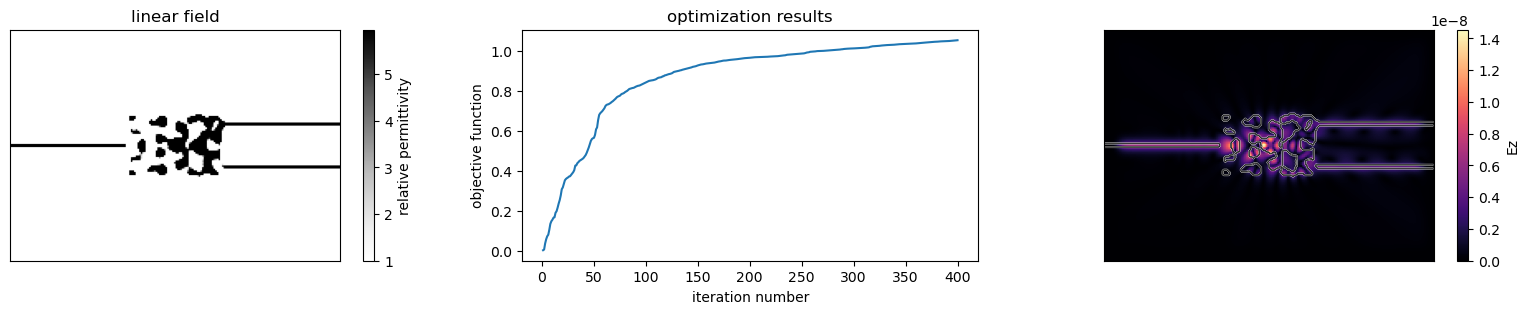

In [14]:
# plot the objective function end structure and fields
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3))

simulation.plt_eps(ax=ax1, outline=False)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')

(_,_,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax3, vmax=None)
ax1.set_title('linear field')

plt.show()

Finally we can measure power transmission of our final `simulation`.

In [ ]:
# plot transmission characteristics
W_in = simulation.W_in   # input power (W/um)

# linear powers
W_top_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl))
W_bot_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl))

print('        -> linear transmission (top)        = {:.2f} %'.format(W_top_lin / W_in * 100))
print('        -> linear transmission (bottom)     = {:.2f} %'.format(W_bot_lin / W_in * 100))

## Conclusion

This was a simple demo of a linear problem.  

For more functionality, please check out our other notebooks!

And if you have a question, feature request, or want to contribute, feel free to reach out on Github.